## Classifying Text and Images

### 1. Text Classification
In this section we will use a purely textual dataset with paper 405 paper reviews with scores ranging from -2 to +2. Our goal is to train a text model to classify things as negative reviews versus positive reviews. Most of the reviews are in Spanish so you might want to use Google Translate or brush up your Spanish if you don't speak it. Here is a link to the dataset and further description of it https://archive.ics.uci.edu/ml/datasets/Paper+Reviews

#### 1.1 Data Exploration and Setup (Always important to explore before jumping to the problem).
First let's do some tinkering with the data. Explore and see what it has. Below I show some common things you want to do for any problem. What is the size of your dataset? What are the annotations in the dataset? What do input samples look like? 

In [1]:
# Download the dataset.
# Information about this dataset in the following URL:
# https://archive.ics.uci.edu/ml/datasets/Paper+Reviews
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json

# Load the dataset into a json structure.
import json
text_data = json.load(open('reviews.json'))

# Let's print some dataset information.
paper_count = len(text_data['paper'])
review_count = sum([len(paper['review']) for paper in text_data['paper']])
print('There are {1} reviews for {0} papers'.format(paper_count, review_count))

# Let's look at the first review for the first paper.
print('\nPaper Review:')
review = text_data['paper'][0]['review'][0]
print('Text: ' + review['text'][:120] + '...') # Too long to print in full.
print('Score: ' + review['evaluation'])

--2020-09-17 23:21:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00410/reviews.json
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593600 (580K) [application/x-httpd-php]
Saving to: ‘reviews.json’

reviews.json        100%[===================>] 579.69K  1.86MB/s    in 0.3s    

2020-09-17 23:21:32 (1.86 MB/s) - ‘reviews.json’ saved [593600/593600]

There are 405 reviews for 172 papers

Paper Review:
Text: - El artículo aborda un problema contingente y muy relevante, e incluye tanto un diagnóstico nacional de uso de buenas p...
Score: 1


Let's collect all reviews and scores into arrays that will be our inputs $X$ and ground truth outputs $Y$. Then let's print five positive and five negative reviews and see if those seem reasonable. You can use Google Translate if you need to. I put code in the comments that you can uncomment so you can see Google Translations in English.

In [2]:
# Don't speak Spanish? No problem. 
!pip install googletrans --quiet
from googletrans import Translator
import numpy as np

# Let's collect all reviews for all papers into a list.
inputs_X = []
outputs_Y = []
for paper in text_data['paper']:
    inputs_X += [p['text'] for p in paper['review']]
    outputs_Y += [int(p['evaluation']) for p in paper['review']]

# Let's also split them into training, and validation (dev).
train_inputs_X = inputs_X[:300]  # The first 300.
train_outputs_Y = np.array(outputs_Y[:300]) # The first 300 (also turn into np.array).

val_inputs_X = inputs_X[300:] # The rest.
val_outputs_Y = np.array(outputs_Y[300:]) # The rest (also turn into np.array)

# Find indices for all reviews with a score of +2.
# Then change this to -2 and see some negative reviews.
inds, = np.nonzero(train_outputs_Y == -2)

# Show the first five.
translator = Translator()
for (ii, ind) in enumerate(inds[:6]):
    if len(train_inputs_X[ind]) > 0: # Apparently some reviews are empty :?
        print(ii)
        print(train_inputs_X[ind])
        out = translator.translate(train_inputs_X[ind], dst = 'en', src = 'es')
        print(out.text)

     |████████████████████████████████| 61kB 2.3MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 962kB 6.3MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
0
Este paper involucra el desarrollo de una aplicación que simule el protocolo BB84, se aprecia un trabajo ordenado y sin duda la comprensión de algunos conceptos de la física cuántica que sustentan la criptografía cuántica como son el teorema de no-clonación y el principio de superposición y entrelazamiento es una labor que tiene sus méritos, además, se aprecia el uso de ingeniería de software en la construcción de la aplicación, lo cual es un aspecto muy positivo, pues generalmente cuando hay involucrado creación de software en áreas de conocimiento de frontera, se recurre al code-and-fix, con todas las desventajas que esto conlleva.  Yo creo que este manuscrito 

#### 1.2 Tokenization
Convert the text for both the training and validation examples into tokens using simple word tokenization. Use a dictionary of 6,000 words containing the most frequent words in the training set. Keep in mind that you will need to have an UNK token in your dictionary to handle out-of-vocabulary words. In class, we will discuss much more advanced tokenization techniques. In practice you want to use an industry strength tokenization library such as https://github.com/huggingface/tokenizers. But a basic tokenizer is written below.


In [36]:
import string 

# Count words.
word_counts = dict()
for text in train_inputs_X:
    for w in text.split(" "):
        word_counts[w] = 1 + word_counts.get(w, 0)

# Sort words based on counts.
sorted_word_counts = sorted(word_counts.items(), key = lambda x: -x[1])

# Build mappings from tokens to ids and ids to tokens.
token_to_id = {entry[0]: id for (id, entry) in enumerate(sorted_word_counts[:6000])}
token_to_id["UNK"] = len(token_to_id)
id_to_token = {id: token for (token, id) in token_to_id.items()}

# Let's write some semi-clean code and create a few Data classes.
class Vocabulary(object):
    def __init__(self, token_to_id: dict, id_to_token: dict):
        self.token_to_id = token_to_id
        self.id_to_token = id_to_token
    def __len__(self) -> int:
        return len(self.token_to_id)

class TextDataset(object):
    def __init__(self, vocabulary: Vocabulary, 
                 input_texts: list, 
                 output_labels: list):
        self.vocab = vocabulary
        self.input_texts = input_texts
        self.output_labels = output_labels
    
    def __getitem__(self, i: int) -> tuple:
        text = self.input_texts[i]
        # Tokenize the text.
        tokenized_text = self.tokenize(text)
        label = self.output_labels[i]
        return tokenized_text, label

    def __len__(self) -> int:
        return len(self.output_labels)

    def tokenize(self, text: str):
        return [self.vocab.token_to_id.get(w, token_to_id["UNK"]) \
                          for w in text.split(" ")]

    def token2index(self, token: str) -> int:
        return self.vocab.token_to_id[token]

    def index2token(self, index: int) -> str:
        return self.vocab.id_to_token[index]

    def untokenize(self, tokens: list):
        return " ".join([self.vocab.id_to_token[w] for w in tokens])

    def vocab_size(self) -> int:
        return len(self.vocab)

# Create instances for the train and validation dataset.
vocabulary = Vocabulary(token_to_id, id_to_token)
train_data = TextDataset(vocabulary, train_inputs_X, train_outputs_Y)
val_data = TextDataset(vocabulary, val_inputs_X, val_outputs_Y)

# Print the length of training and validation.
print(len(train_data))
print(len(val_data))

# Test the tokenization and untokenization.
x,y = train_data[130]
print(x)
print(train_data.untokenize(x))
#print(train_data.tokenize("I love the course"))
print(train_data.vocab_size())

300
105
[107, 1329, 295, 13, 1813, 10, 5937, 1057, 11, 249, 2802, 50, 156, 1, 209, 6, 4, 54, 1267, 36, 579, 0, 516, 3, 4, 342, 2, 186, 425, 0, 5, 10, 52, 27, 211, 23, 55, 5938, 3, 4, 898, 27, 191, 1104, 4, 20, 15, 31, 96, 3, 4, 1829, 0, 1830, 0, 804, 1816]
Este paper, según los revisores, no contempla directamente una contribución científica, sin embargo la experiencia y el tema tratado son interesantes de presentar en el congreso.  A pesar de que no puede ser presentado como paper regular en el congreso, ser recomienda aceptar el artículo para su presentación en el workshop de educación de Infonor 2013.
6001


#### 1.3 Text encoding (Bag of words -- BOW) 
Make sure all lines of code up to this point are cleanly understood. If not, ask questions on Campuswire or during office hours. Now we move to encoding the input sentences. We will write code here for encoding the sentences using Unigrams -- (single words). Throughout the class we will discuss more advanced encodings of text, such as Continuous Bag-of-words (CBOW) with word embeddings and transformer-based encodings using a pretrained encoder such as BERT.

In [4]:
x, y = train_data[123]

def encode_text(tokens):
    token_ids = np.array(tokens)
    bow_vector = np.zeros((1, train_data.vocab_size())) # Start with all zeros.
    bow_vector[0, token_ids] = 1 # Put ones in token_id locations.
    return bow_vector

# This should print the BOW encoding for input x.
print(encode_text(x).shape)
print(encode_text(x)[0, 13])
print(x)


(1, 6001)
1.0
[17, 272, 295, 13, 1813, 10, 34, 11, 249, 664, 721, 3, 4, 155, 0, 1103, 24, 135, 5845, 50, 156, 12, 11, 45, 37, 47, 9, 27, 990, 3, 4, 1814, 0, 5846, 0, 1815, 1816, 83, 21, 571, 5, 7, 191, 1104, 4, 20, 15, 31, 2781]


#### 1.4 Building and train a Linear Text Classifier (Pytorch)
Now we can build a binary linear classifier and train it using SGD. We will rely on the Pytorch library for this purpose but we could use any. We don't need to compute gradients analytically since Pytorch keeps track of operations. 

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Let's define a linear classifier (One layer neural network).
# Pytorch supports batches so this model already can receive a set of inputs
# and not just one vector at a time.
class LinearClassifier(nn.Module): 
    def __init__(self, encoding_size):
        super(LinearClassifier, self).__init__()
        # The classifier will be binary either positive or negative review.
        # So we only need one output variable in the linear layer.
        self.linear = nn.Linear(encoding_size, 1) 

    # Apply the linear operation and the sigmoid operation.
    def forward(self, encoded_input):
        return torch.sigmoid(self.linear(encoded_input))

Now let's train the model using a manual for-loop.

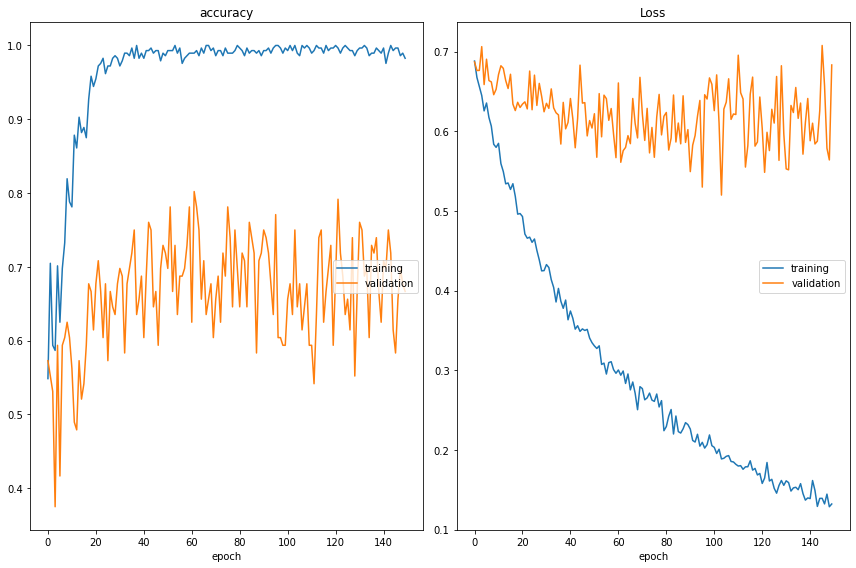

accuracy
	training         	 (min:    0.549, max:    1.000, cur:    0.983)
	validation       	 (min:    0.375, max:    0.802, cur:    0.667)
Loss
	training         	 (min:    0.129, max:    0.688, cur:    0.132)
	validation       	 (min:    0.520, max:    0.708, cur:    0.683)


<All keys matched successfully>

In [6]:
!pip install livelossplot --quiet

import random
import torch.optim as optim
from livelossplot import PlotLosses

n_epochs = 150
batch_size = 16
learningRate = 2e-4
encodingSize = train_data.vocab_size()

# Code to sample a random batch.
def sample_batch(data, batch_size):
    input_x = np.zeros((batch_size, encodingSize))
    output_y = np.zeros(batch_size)
    for i in range(0, batch_size):
        random_index = random.randint(0, len(data) -  1)
        tokens, label = data[random_index]
        input_x[i, :] = encode_text(tokens)
        output_y[i] = 1 if (label > 0) else 0
    return input_x, output_y

# Code that runs the SGD optimization loop.
model = LinearClassifier(encodingSize) # Our model.

cost_function = nn.BCELoss()  # Our loss function.
#optimizer = optim.SGD(model.parameters(), lr = learningRate)
optimizer = optim.Adam(model.parameters(), lr = learningRate)

best_accuracy = 0 
liveloss = PlotLosses()
for epoch in range(0, n_epochs):
    correct = 0
    cumulative_loss = 0
    logs = {}
    n_batches = int(len(train_data) / batch_size)
    model.train()
    for batch_id in range(0, n_batches):
        model.zero_grad()

        # Sample batch.
        xb, yb = sample_batch(train_data, batch_size)

        # Move data to pytorch tensors.
        xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True)
        yb = torch.tensor(yb, dtype=torch.float32)

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb[:, None])
        cumulative_loss += loss.data
        correct += ((predicted > 0.5) == yb[:, None]).sum().item()

        # Compute gradients (autograd).
        loss.backward()

        # Run one basic training step of SGD.
        optimizer.step()
        #for param in model.parameters():
        #    param.data.add_(-learningRate * param.grad.data)

        logs['loss'] = cumulative_loss / (1 + batch_id)
        logs['accuracy'] = correct / ((1 + batch_id) * batch_size)
    
    #print('\nEpoch {0} ended with a train-loss of {1:.4f} and training accuracy of {2:.2f}'
    #        .format(epoch, cumulative_loss / (1 + batch_id), correct / ((1 + batch_id) * batch_size)))
    
    correct = 0
    cumulative_loss = 0
    n_batches = int(len(val_data) / batch_size)
    model.eval()
    with torch.no_grad():
        for batch_id in range(0, n_batches):
            # Sample batch.
            xb, yb = sample_batch(val_data, batch_size)

            # Move data to pytorch tensors.
            xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True)
            yb = torch.tensor(yb, dtype=torch.float32)
        
            # Compute predictions.
            predicted = model(xb)

            # Compute loss.
            loss = cost_function(predicted, yb[:, None])
            cumulative_loss += loss.data
            correct += ((predicted > 0.5) == yb[:, None]).sum().item()

            logs['val_loss'] = cumulative_loss / (1 + batch_id)
            logs['val_accuracy'] = correct / ((1 + batch_id) * batch_size)

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    liveloss.update(logs)
    liveloss.send()
    #print('Epoch {0} ended with a validation-loss of {1:.4f} and validation-accuracy of {2:.2f}'
    #        .format(epoch, cumulative_loss / n_batches, correct / (n_batches * batch_size)))

# Load the model parameters for the one that achieved the best val accuracy.
model.load_state_dict(torch.load('best_model_so_far.pth'))    

#### 1.5 Sanity checks
Is this model working? Is our model displaying any sign of intelligence? The loss is going down and the accuracy is going up on the training data... but... the validation loss and validation accuracy seems still low after several epochs e.g. between 60-70% accuracy. Our training data is too small and the validation set is small as well so it is hard to trust these results as conclusive. But here I will show some things we can do to analyze these results further.

##### 1.5.1 So the model is better than random guessing but is the model better than just guessing the majority class? e.g. if 60% of the reviews are negative, then predicting everything as negative should also lead to 60% accuracy. Let's compute this number.

In [ ]:
count_positives = 0
for i in range(0, len(val_data)):
    _, y = val_data[i]
    count_positives += (y > 0)

print('Percentage of negatives {0:.2f}'.
      format(1 - (count_positives / len(val_data))))

Percentage of negatives 0.55


##### 1.5.2 The model is better than always predicting negative on our validation set. However, we would need to compute the accuracy on a test set. We don't have a test set here. There are other things we could do. We can also look at the kind of predictions the model makes e.g. what is the model predicting as positives? What are the largest weights learned to predict something as positive? Keep in mind that our model is learning $$Y=sigmoid(WX + b)$$, so ignoring the scaling parameter b, let's see what does W have for each input uni-gram (token).

In [ ]:
W = model.linear.weight.data
print(W.shape)  # This prints (1, 5001) since we have 5,000 tokens + UNK token.

# Most positive tokens.
sorted_vals, sorted_ids = W.sort(dim = 1, descending = True)
positive_tokens = [train_data.index2token(sid.item()) for sid in sorted_ids[0, :20]]
positive_tokens_en = [translator.translate(token, dst = 'en', src = 'es').text for token in positive_tokens]
print(positive_tokens)
print(positive_tokens_en)

# Most negative tokens.
sorted_vals, sorted_ids = W.sort(dim = 1, descending = False)
negative_tokens = [train_data.index2token(sid.item()) for sid in sorted_ids[0, :20]]
negative_tokens_en = [translator.translate(token, dst = 'en', src = 'es').text for token in negative_tokens]
print(negative_tokens)
print(negative_tokens_en)

torch.Size([1, 6001])
['prácticas.', 'recomienda', 'estructurado', 'través', 'profundizar', 'agentes', 'problemática', 'basado', 'publicación', 'colaboración', 'sensores', 'authors', 'good', '2,', 'realizado.', 'factor', 'Revisar', 'tema', 'adopción', 'polos']
['practices.', 'recommends', 'structured', 'through', 'deepen', 'agents', 'troublesome', 'based', 'publication', 'collaboration', 'sensors', 'authors', 'good', 'two,', 'accomplished.', 'factor', 'Check', 'topic', 'adoption', 'poles']
['tampoco', 'ni', 'Tampoco', 'tiene', 'teórico', 'Problemas', 'finalizar', 'redacción,', 'aportes', 'comparar', 'Además', 'presenta,', 'aporte,', 'imágenes,', 'procesos', 'punto', 'literatura', '(que', 'forma,', 'formales']
['neither', 'neither', 'Neither', 'have', 'theoretical', 'problems', 'Finalize', 'drafting,', 'contributions', 'compare', 'Also', 'presents,', 'input,', 'images,', 'processes', 'point', 'literature', '(than', 'shape,', 'formal']


You can see here that positive words include some obvious tokens such as "bien" (good/well), "nivel" (level/caliber), "orden" (order / as in well organized), but also other surprising things such as "software" and "basado" (based) -- so maybe reviewers prefer work that builts on previous work and that includes software as a by-product. On the other hand negative tokens include obvious things such as "No", "no" (no, not), "ni" (neither), "falta" (lacking/lack), "menos" (less), "pero" (but), "problema" (problem), "mal" (bad/wrong). Negative reviews also include things that might be more informative such as reviewers being negatively biased if they perceive the technical aspects are lacking e.g. "técnico" (technical), or the model probably lacks comparisons "comparación". Negative reviews also show more opinionated statements such as "Creo" (I believe), "Se" (I know), "Además" (On top of... / Also...). So possibly the model is learning something smart not just random guessing. Obviously this model is a unigram model so it can't distinguish sentences that say "clearly good" from sentences saying "clearly bad", so the model treats the word clearly the same for both cases. However, we can see that people prefer to use the word "clearly" (claramente) when they want to say something negative.

Note: These tokens will change depending on your model -- so you might not see the same tokens every time you run the code again. Also keep in mind that the classification scores do not depend only on the token weights but also on the inputs -- so these weight interpretations are only to give us an idea but are not calibrated.

##### 1.5.3 We should also look at the examples that are predicted as highly positive and highly negative by this model and see if those look reasonable. Would you make similar predictions if you read the text?

In [ ]:
model.eval()
scores = torch.zeros((len(val_data)))

# We didn't store predictions for the validation set so let's recompute.
# Also no need to use batches here.
with torch.no_grad():
    for i in range(0, len(val_data)):
        x, y = val_data[i]
        x = encode_text(x)

        xb = torch.tensor(x, dtype=torch.float32)
        yb = torch.tensor(y, dtype=torch.float32)

        score = model(xb)
        # item() converts the tensor to a scalar value.
        scores[i] = score[0,0].item()

# sort in descending order.
sorted_values, sorted_inds = scores.sort(descending = True)

# Show the top 10 predictions by score.
correct = 0
topK = 10
for (ind, score) in zip(sorted_inds[:topK].numpy(), sorted_values[:topK].numpy()):
    x, y = val_data[ind]
    text = val_data.untokenize(x)
    print(y, score, text)
    correct += ((y > 0) == (score > 0.5))

print('{0} out of {1} predictions are correct'.format(correct, topK))

1 0.61834073 This work UNK UNK results and UNK a UNK for further UNK I would UNK in UNK of UNK the use of UNK UNK for UNK UNK UNK for UNK and UNK for UNK In UNK there are some UNK UNK UNK in the UNK that can be used and study, as for UNK UNK or other similar systems. I UNK UNK to see clearly UNK in the paper, the use of the UNK UNK UNK UNK UNK used for UNK robot. In UNK 7, it seems that UNK UNK is UNK than that UNK with UNK UNK UNK to UNK error, but in my opinion it is not very clear UNK UNK UNK I would UNK think if is it there some UNK UNK of UNK results to UNK in order to UNK UNK error.
0 0.5828866 El trabajo es una excelente guía para UNK un UNK UNK muy bien escrito, en donde utiliza bibliografía y conocimientos de UNK y UNK UNK literatura UNK Es un trabajo de investigación UNK  original y  una aplicación muy interesante en una empresa.  UNK UNK  Falta UNK una sección de trabajos UNK UNK medir el grado de efectividad de su UNK en una sección de análisis de resultados y UNK
2 0.57914

##### 1.5.4 It is also strongly recommended to try your model. See what the model predicts -- maybe even build a demo where you can toy with your model on a user interface and have other people try your model to see if it matches their expectations. Let's do that here:

In [ ]:
my_text = "Creo que el paper no tiene comparaciones adecuadas con respecto a estudios previos en la literatura." + \
          "Tiene una contribución técnica menor y carece de experimentos para validar " + \
          "algunas de las contribuciones e hipótesis planteadas."

#my_text = "El paper tiene excelentes resultados y muy buenas comparaciones con la literatura previa. Recomiendo que sea aceptado."
#my_text = "Excelente trabajo, este paper merece estar en la conferencia. Resultados experimentales satisfactorios."
#my_text = "No hay suficientes experimentos y falta desarrollar las ideas. Además hay una mala presentación."

tokenized = train_data.tokenize(my_text)
encoded_text = encode_text(tokenized)

input_tensor = torch.tensor(encoded_text, dtype = torch.float32, requires_grad = False)

model.eval() # Set to evaluation mode. IMPORTANT!
predictions = model(input_tensor)

print(predictions[0,0].item())

0.4956197440624237


If you are working with a language you don't speak you can rely on Google Translate as you develop things but you probably want to consult with speakers of the language and learn it yourself (to some extent at least). The early you involve a person with specific knowledge about the language could avoid wasted efforts. e.g. you might be tempted to put everything in lowercase as a pre-processing step -- but are you aware of how uppercase is used in a language such as German? Putting everything in lowercase for German might be a specially bad idea. 

### Assignment [100pts]

#### 1. Sub-word level tokenizers [30pts]

Use the "bert-base-multilingual-cased" tokenizers from hughingface's tokenizer library to reimplement the class below -- or implement on your own any subword level tokenizer.

In [7]:
!pip install transformers --quiet
from transformers import BertTokenizer

class AdvancedTextDataset(object):
    def __init__(self, input_texts: list, 
                 output_labels: list):
        self.input_texts = input_texts
        self.output_labels = output_labels
        # Use the sub-word tokenizers from the library here.
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


    def __getitem__(self, i: int) -> tuple:
        text = self.input_texts[i]
        # Tokenize the text.
        tokenized_text = self.tokenize(text)
        label = self.output_labels[i]
        print(tokenized_text)
        return tokenized_text, label

    def __len__(self) -> int:
        return len(self.output_labels)

    def tokenize(self, text: str):
        # Use the sub-word tokenizers from the library here.
        encoding = self.tokenizer.encode_plus(
                    text,
                    truncation=True,
                    max_length=512,return_tensors='pt',  # Return PyTorch tensors
                  )
        token_ids=encoding['input_ids'][0]
        #a = self.tokenizer.tokenize(text)
        #b = self.tokenizer.convert_tokens_to_ids(a)
        return token_ids

    def untokenize(self, tokens: list):
        # Use the sub-word tokenizers from the library here.
        #return self.tokenizer.convert_tokens_to_string(tokens)
        token=self.tokenizer.convert_ids_to_tokens(tokens)
        untok=self.tokenizer.convert_tokens_to_string(token)
        return untok
        #pass


#untok=self.tokenizer.convert_tokens_to_string(token)
    def token2index(self, token: str) -> int:
        # Use the sub-word tokenizers from the library here.
        return self._convert_token_to_id(token)

    def index2token(self, index: int) -> str:
        # Use the sub-word tokenizers from the library here.
        return self._convert_id_to_token(index)

    def vocab_size(self) -> int:
        # Use the sub-word tokenizers from the library here.
        return len(self.tokenizer.vocab)
   #     return self.vocab_size()

# Create instances for the train and validation dataset.
adv_train_data = AdvancedTextDataset(train_inputs_X, train_outputs_Y)
adv_val_data = AdvancedTextDataset(val_inputs_X, val_outputs_Y)

# Print the length of training and validation.
print(len(adv_train_data))
print(len(adv_val_data))

# Test the tokenization and untokenization.
x,y = adv_val_data[10]
#print(x)
print(adv_val_data.untokenize(x))
print(adv_val_data.vocab_size())

     |████████████████████████████████| 890kB 2.1MB/s 
     |████████████████████████████████| 1.1MB 10.9MB/s 
     |████████████████████████████████| 890kB 16.4MB/s 
     |████████████████████████████████| 3.0MB 18.7MB/s 



300
105
tensor([   101,  10224,  41249,  15882,  10119,  18100,  10104,  11639,  40950,
         18854,  10104,  22029,    117,  10198,  16942,  92189,  10810,    193,
         52909,    117,  10110,  10125,  56992,  10104,  23037,  18854,  10104,
         11639, 110491,    119,    122,    119,    140,  33472,  10121,    117,
         16943,  10104,  10109,  69157,  10110,  51430,    193,  23213,  10104,
         19575,  29213,  10107,    117,  21751,  93390,  10341,  11564,  46779,
         10107,  97377,  10110,  50219,  58339,    117,  10182,  21093,  89853,
         10192,  10126,  17553,  10206,  10110,  22972,  53149,    119,  10243,
         10547,  25422,    117,  10153,  10110,  12352,  18487,  15483,  64615,
         10104,  31854,  73409,  29758,  34768,  95941,  19860, 102388,    193,
         25470, 104071,  12715,  10164,  21037,    119,    123,    119,  57943,
         10127,  41249,  10126,  55757,  36070,  39540,    193,  91976,  10107,
           119,  10657,  40455,

Train the model here and show your train/validation plots for losses and accuracies while using this new tokenization. Is it slower? Why?

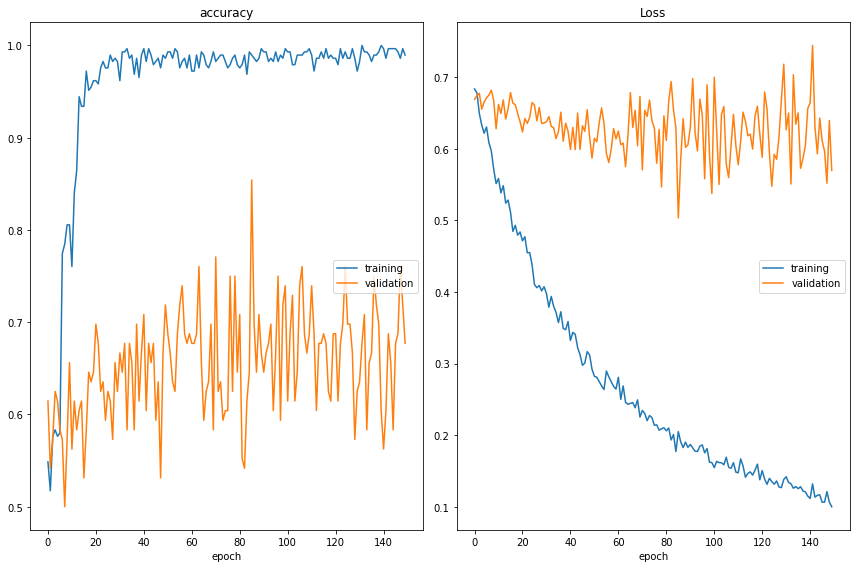

accuracy
	training         	 (min:    0.517, max:    1.000, cur:    0.990)
	validation       	 (min:    0.500, max:    0.854, cur:    0.677)
Loss
	training         	 (min:    0.100, max:    0.683, cur:    0.100)
	validation       	 (min:    0.503, max:    0.744, cur:    0.570)


<All keys matched successfully>

In [10]:
# Your code goes here. Feel free to just modify code included on this document.
!pip install livelossplot --quiet

#x, y = train_data[123]

def encode_text(tokens):
    token_ids = np.array(tokens)
    print (token_ids.shape)
    bow_vector = np.zeros((1, adv_train_data.vocab_size())) # Start with all zeros.
    bow_vector[0, token_ids] = 1 # Put ones in token_id locations.
    return bow_vector


import random
import torch.optim as optim
from livelossplot import PlotLosses

n_epochs = 150
batch_size = 16
learningRate = 2e-4
encodingSize = adv_train_data.vocab_size()

# Code to sample a random batch.
def sample_batch(data, batch_size):
    input_x = np.zeros((batch_size, encodingSize))
    output_y = np.zeros(batch_size)
    for i in range(0, batch_size):
        random_index = random.randint(0, len(data) -  1)
        tokens, label = data[random_index]
        input_x[i, :] = encode_text(tokens)
        output_y[i] = 1 if (label > 0) else 0
    return input_x, output_y

# Code that runs the SGD optimization loop.
model = LinearClassifier(encodingSize) # Our model.

cost_function = nn.BCELoss()  # Our loss function.
#optimizer = optim.SGD(model.parameters(), lr = learningRate)
optimizer = optim.Adam(model.parameters(), lr = learningRate)

best_accuracy = 0 
liveloss = PlotLosses()
for epoch in range(0, n_epochs):
    correct = 0
    cumulative_loss = 0
    logs = {}
    n_batches = int(len(adv_train_data) / batch_size)
    model.train()
    for batch_id in range(0, n_batches):
        model.zero_grad()

        # Sample batch.
        xb, yb = sample_batch(adv_train_data, batch_size)

        # Move data to pytorch tensors.
        xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True)
        yb = torch.tensor(yb, dtype=torch.float32)

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb[:, None])
        cumulative_loss += loss.data
        correct += ((predicted > 0.5) == yb[:, None]).sum().item()

        # Compute gradients (autograd).
        loss.backward()

        # Run one basic training step of SGD.
        optimizer.step()
        #for param in model.parameters():
        #    param.data.add_(-learningRate * param.grad.data)

        logs['loss'] = cumulative_loss / (1 + batch_id)
        logs['accuracy'] = correct / ((1 + batch_id) * batch_size)
    
    #print('\nEpoch {0} ended with a train-loss of {1:.4f} and training accuracy of {2:.2f}'
    #        .format(epoch, cumulative_loss / (1 + batch_id), correct / ((1 + batch_id) * batch_size)))
    
    correct = 0
    cumulative_loss = 0
    n_batches = int(len(adv_val_data) / batch_size)
    model.eval()
    with torch.no_grad():
        for batch_id in range(0, n_batches):
            # Sample batch.
            xb, yb = sample_batch(adv_val_data, batch_size)

            # Move data to pytorch tensors.
            xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True)
            yb = torch.tensor(yb, dtype=torch.float32)
        
            # Compute predictions.
            predicted = model(xb)

            # Compute loss.
            loss = cost_function(predicted, yb[:, None])
            cumulative_loss += loss.data
            correct += ((predicted > 0.5) == yb[:, None]).sum().item()

            logs['val_loss'] = cumulative_loss / (1 + batch_id)
            logs['val_accuracy'] = correct / ((1 + batch_id) * batch_size)

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    liveloss.update(logs)
    liveloss.send()
    #print('Epoch {0} ended with a validation-loss of {1:.4f} and validation-accuracy of {2:.2f}'
    #        .format(epoch, cumulative_loss / n_batches, correct / (n_batches * batch_size)))

# Load the model parameters for the one that achieved the best val accuracy.
model.load_state_dict(torch.load('best_model_so_far.pth'))    

yes, it is slower, because the encodingSize is larger here so the run time is longer.


#### 2. BERT Encoding [20pts]



The code below computes BERT encodings given an input that is tokenized using a BERT encoder such as the one you implemented earlier. This converts the input tokenized sentence into a vector with a pretrained model. Please see the documentation for what bert_encoder.forward returns. For this part I only request you to train the model using this text encoder function instead of the bag of words encoding used in the tutorial part of this notebook. Note: This part requires using GPU computing so go to Runtime -> Change Runtime type and choose GPU. You might need to re-run some earlier cells. You are also welcome to try not using the GPU so you can experience how much longer this code takes to execute.

In [33]:
import torch
!pip transformers
from transformers import BertModel

x, y = adv_train_data[123]

bert_encoder = BertModel.from_pretrained("bert-base-multilingual-cased")
bert_encoder.eval()
bert_encoder = bert_encoder.cuda()

def encode_text(tokens):
    inputs = torch.tensor(tokens, requires_grad = False).cuda()
    bert_vector = bert_encoder(inputs[None, :])
    return bert_vector[1].data.cpu().numpy()

# This should print the BOW encoding for input x.
print(encode_text(x).shape)


ERROR: unknown command "transformers"
tensor([   101,  10224,  18100,    117,  16029,  10182,  86095, 105580,  10171,
           117,  10192,  15882,  10153,  60146,  61761,  29213,  46169,  10110,
         10125,  13487,  10104,  25470,  53938,  13640,    183,  24757,  10120,
         55729,  10310,    117,  10795,  14668,  10196,  10153,  46553,  13436,
        109686,    169,  10493,  15882,  10229,  10110,  10125,  62543,  10104,
         20386,  84722,  10104,  36351,  11565,  30118,  42622,  10207,    119,
         10912,  10183,  22690,  10121,  10126,  11639,  22530,  53781, 109078,
         10125,  41249,  10220,  10198,  60170,    119,    102])
(1, 768)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Print your training/validation loss/accuracy plots here.

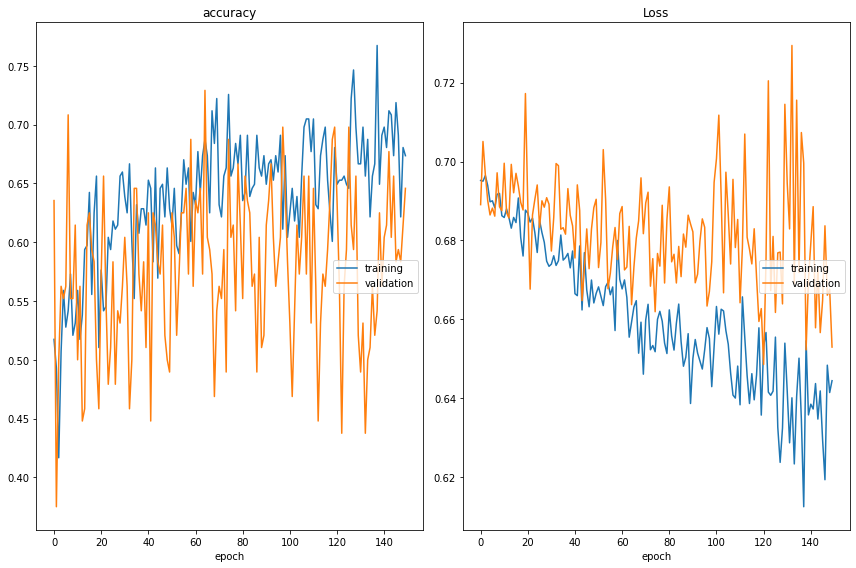

accuracy
	training         	 (min:    0.417, max:    0.767, cur:    0.674)
	validation       	 (min:    0.375, max:    0.729, cur:    0.646)
Loss
	training         	 (min:    0.613, max:    0.696, cur:    0.644)
	validation       	 (min:    0.649, max:    0.729, cur:    0.653)


<All keys matched successfully>

In [34]:
# Your code goes here. Feel free to just modify code included on this document.
import random
import torch.optim as optim
from livelossplot import PlotLosses

n_epochs = 150
batch_size = 16
learningRate = 2e-4
encodingSize = encode_text(x).shape[1]

# Code to sample a random batch.
def sample_batch(data, batch_size):
    input_x = np.zeros((batch_size, encodingSize))
    output_y = np.zeros(batch_size)
    for i in range(0, batch_size):
        random_index = random.randint(0, len(data) -  1)
        tokens, label = data[random_index]
        input_x[i, :] = encode_text(tokens)
        output_y[i] = 1 if (label > 0) else 0
    return input_x, output_y

# Code that runs the SGD optimization loop.
model = LinearClassifier(encodingSize) # Our model.

cost_function = nn.BCELoss()  # Our loss function.
#optimizer = optim.SGD(model.parameters(), lr = learningRate)
optimizer = optim.Adam(model.parameters(), lr = learningRate)

best_accuracy = 0 
liveloss = PlotLosses()
for epoch in range(0, n_epochs):
    correct = 0
    cumulative_loss = 0
    logs = {}
    n_batches = int(len(adv_train_data) / batch_size)
    model.train()
    for batch_id in range(0, n_batches):
        model.zero_grad()

        # Sample batch.
        xb, yb = sample_batch(adv_train_data, batch_size)

        # Move data to pytorch tensors.
        xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True)
        yb = torch.tensor(yb, dtype=torch.float32)

        # Compute predictions.
        predicted = model(xb)

        # Compute loss.
        loss = cost_function(predicted, yb[:, None])
        cumulative_loss += loss.data
        correct += ((predicted > 0.5) == yb[:, None]).sum().item()

        # Compute gradients (autograd).
        loss.backward()

        # Run one basic training step of SGD.
        optimizer.step()
        #for param in model.parameters():
        #    param.data.add_(-learningRate * param.grad.data)

        logs['loss'] = cumulative_loss / (1 + batch_id)
        logs['accuracy'] = correct / ((1 + batch_id) * batch_size)
    
    #print('\nEpoch {0} ended with a train-loss of {1:.4f} and training accuracy of {2:.2f}'
    #        .format(epoch, cumulative_loss / (1 + batch_id), correct / ((1 + batch_id) * batch_size)))
    
    correct = 0
    cumulative_loss = 0
    n_batches = int(len(adv_val_data) / batch_size)
    model.eval()
    with torch.no_grad():
        for batch_id in range(0, n_batches):
            # Sample batch.
            xb, yb = sample_batch(adv_val_data, batch_size)

            # Move data to pytorch tensors.
            xb = torch.tensor(xb, dtype=torch.float32, requires_grad = True)
            yb = torch.tensor(yb, dtype=torch.float32)
        
            # Compute predictions.
            predicted = model(xb)

            # Compute loss.
            loss = cost_function(predicted, yb[:, None])
            cumulative_loss += loss.data
            correct += ((predicted > 0.5) == yb[:, None]).sum().item()

            logs['val_loss'] = cumulative_loss / (1 + batch_id)
            logs['val_accuracy'] = correct / ((1 + batch_id) * batch_size)

    # Save the parameters for the best accuracy on the validation set so far.
    if logs['val_accuracy'] > best_accuracy:
        best_accuracy = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_so_far.pth')

    liveloss.update(logs)
    liveloss.send()
    #print('Epoch {0} ended with a validation-loss of {1:.4f} and validation-accuracy of {2:.2f}'
    #        .format(epoch, cumulative_loss / n_batches, correct / (n_batches * batch_size)))

# Load the model parameters for the one that achieved the best val accuracy.
model.load_state_dict(torch.load('best_model_so_far.pth'))    


#### 3. Image Classification [50pts]
Same as in text classification you can build image classifiers. Here I pose the problem of scene classification. Train a convolutional neural network (feel free to use a pretrained model or create one on your own) -- however this dataset is small so it is better to use a pretrained model. Unlike the text classification example this task requires multiple labels so you need to use a different loss function. 

I am providing here with the code to download and for the data loader. Unlike the assignment in the Deep Learning for Visual Recognition class, you don't need to implement anything from scratch for this assignment -- use Pytorch to create and train your convolutional neural network.

In [24]:
!wget -nc http://www.cs.virginia.edu/~vicente/deeplearning/sun20_48x48_validation.pth
!wget -nc http://www.cs.virginia.edu/~vicente/deeplearning/sun20_48x48_train.pth
!wget -nc http://vicenteordonez.com/deeplearning/dataset.py

File ‘sun20_48x48_validation.pth’ already there; not retrieving.

File ‘sun20_48x48_train.pth’ already there; not retrieving.

File ‘dataset.py’ already there; not retrieving.



<class 'dataset.SUN20'>
This dataset has 1000 training images
Image 121 is a bathroom
Image size is 3x48x48


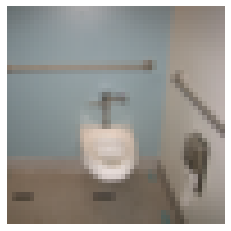

torch.Size([3, 48, 48])


In [25]:
import torch, torchvision, matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import dataset

image_index = 121  # Feel free to change this.

# 20 scene categories from the SUN397 dataset.
classes = ['airport_terminal', 'arch', 'bathroom', 'butte', 'castle', 
           'classroom', 'dentists_office', 'hot_spring', 'jacuzzi', 
           'laundromat', 'lecture_room', 'lighthouse', 'mountain', 
           'sauna', 'server_room', 'shower', 'skyscraper', 'tower',
           'tree_house', 'volcano']

trainset = dataset.SUN20(split = 'train')
valset = dataset.SUN20(split = 'validation')

print(type(trainset))
# 1. Datasets need to implement the __len__ method for this to work.
print('This dataset has {0} training images'.format(len(trainset)))

# 2. Datasets need to implement the  __getitem__ method for this to work.
img, label = trainset[image_index]  # Returns image and label.

img = F.to_tensor(img)



print('Image {0} is a {1}'.format(image_index, classes[label]))
print('Image size is {0}x{1}x{2}'.format(img.shape[0], img.shape[1], img.shape[2]))
# All images have 1 channel x 28 rows x 28 columns.

plt.figure()
plt.imshow(img.transpose(0,2).transpose(0,1));
plt.grid(False); plt.axis('off')
plt.show()
print(img.shape)

#print(trainset[3][1])

train_x, train_y = trainset[3]
#train_x = train_x.reshape(54000, 1, 28, 28)
#train_x  = torch.from_numpy(train_x)



In [32]:
#I used both AlexNet and ResNet-50 for this part of the assignment
#ResNet-50
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

#cnn_model = models.alexnet(pretrained = True)
#cnn_model = models.inception_v3(pretrained = True)
#cnn_model.classifier = nn.Linear(4096, 20)
#cnn_model.eval();

cnn_model = models.resnet50(pretrained = True)

cnn_model.fc = nn.Sequential(nn.Linear(2048, 20))


transform = transforms.Compose([transforms.ToTensor()])


# train_transform = transforms.Compose(
#     [transforms.Resize(256),  # 1. Resize smallest side to 256.
#      transforms.RandomCrop(224), # 2. Crop random square of 224x224 pixels.
#      transforms.RandomHorizontalFlip(),
#      transforms.ToTensor(), # 3. Convert to pytorch tensor.
#      transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
#                           std = [0.229, 0.224, 0.225])])

# test_transform = transforms.Compose(
#     [transforms.Resize(256),  # 1. Resize smallest side to 256.
#      transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
#      transforms.ToTensor(), # 3. Convert to pytorch tensor.
#      transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
#                           std = [0.229, 0.224, 0.225])])

trainset = dataset.SUN20(split = 'train', transform = transform)
valset = dataset.SUN20(split = 'validation', transform = transform)

#pytorch DataLoader for iterating over batches
batchSize = 100

#Create the model
#model = TwoLayerNN()
loss_fn = nn.CrossEntropyLoss()

#Defining a learning rate
learningRate = 5e-4

#optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr = 1e-4)

def train_model(model, loss_fn, batchSize, trainset, valset, optimizer):
  
  # Shuffling is needed in case dataset is not shuffled by default.
  train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                              batch_size = batchSize,
                                              shuffle = True)
  # We don't need to bach the validation set but let's do it anyway.
  val_loader = torch.utils.data.DataLoader(dataset = valset,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.

# Define number of epochs.
  N = 20

  # log accuracies and losses.
  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  # GPU enabling.
  model = model.cuda()
  loss_fn = loss_fn.cuda()


  # Training loop. Please make sure you understand every single line of code below.
  # Go back to some of the previous steps in this lab if necessary.
  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      # Make a pass over the training data.
      model.train()
      for (i, (inputs, labels)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          loss = loss_fn(scores, labels)

          # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()
          cum_loss += loss.item()

          # Zero the gradients in the network.
          optimizer.zero_grad()

          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          cum_loss += loss_fn(scores, labels).item()

           # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))

      # Logging the current results on validation.
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
      
      
train_model(cnn_model, loss_fn, batchSize, trainset, valset, optimizer)

Validation-epoch 0. Avg-Loss: 2.6635, Accuracy: 0.2450
Validation-epoch 1. Avg-Loss: 2.2780, Accuracy: 0.4200
Validation-epoch 2. Avg-Loss: 1.8471, Accuracy: 0.5190
Validation-epoch 3. Avg-Loss: 1.5673, Accuracy: 0.5480
Validation-epoch 4. Avg-Loss: 1.4204, Accuracy: 0.5670
Validation-epoch 5. Avg-Loss: 1.3650, Accuracy: 0.5700
Validation-epoch 6. Avg-Loss: 1.3275, Accuracy: 0.5820
Validation-epoch 7. Avg-Loss: 1.3152, Accuracy: 0.5770
Validation-epoch 8. Avg-Loss: 1.3172, Accuracy: 0.5810
Validation-epoch 9. Avg-Loss: 1.3187, Accuracy: 0.5730
Validation-epoch 10. Avg-Loss: 1.3197, Accuracy: 0.5730
Validation-epoch 11. Avg-Loss: 1.3170, Accuracy: 0.5780
Validation-epoch 12. Avg-Loss: 1.3121, Accuracy: 0.5780
Validation-epoch 13. Avg-Loss: 1.3131, Accuracy: 0.5790
Validation-epoch 14. Avg-Loss: 1.3119, Accuracy: 0.5780
Validation-epoch 15. Avg-Loss: 1.3184, Accuracy: 0.5790
Validation-epoch 16. Avg-Loss: 1.3232, Accuracy: 0.5790
Validation-epoch 17. Avg-Loss: 1.3124, Accuracy: 0.5840
Va

In [31]:
#I used both AlexNet and ResNet-50 for this part of the assignment
#AlexNet
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

cnn_model = models.alexnet(pretrained = True)
#cnn_model = models.inception_v3(pretrained = True)
cnn_model.classifier[6] = nn.Linear(4096, 20)
cnn_model.eval();

#cnn_model = models.resnet50(pretrained = True)

#cnn_model.fc = nn.Sequential(nn.Linear(2048, len(classes)))


#transform = transforms.Compose([transforms.ToTensor()])


train_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.RandomCrop(224), # 2. Crop random square of 224x224 pixels.
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

test_transform = transforms.Compose(
    [transforms.Resize(256),  # 1. Resize smallest side to 256.
     transforms.CenterCrop(224), # 2. Crop center square of 224x224 pixels.
     transforms.ToTensor(), # 3. Convert to pytorch tensor.
     transforms.Normalize(mean = [0.485, 0.456, 0.406],  # normalize.
                          std = [0.229, 0.224, 0.225])])

trainset = dataset.SUN20(split = 'train', transform = train_transform)
valset = dataset.SUN20(split = 'validation', transform = test_transform)

#pytorch DataLoader for iterating over batches
batchSize = 100

#Create the model
#model = TwoLayerNN()
loss_fn = nn.CrossEntropyLoss()

#Defining a learning rate
learningRate = 5e-4

#optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr = 1e-4)

def train_model(model, loss_fn, batchSize, trainset, valset, optimizer):
  
  # Shuffling is needed in case dataset is not shuffled by default.
  train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                              batch_size = batchSize,
                                              shuffle = True)
  # We don't need to bach the validation set but let's do it anyway.
  val_loader = torch.utils.data.DataLoader(dataset = valset,
                                            batch_size = batchSize,
                                            shuffle = False) # No need.

# Define number of epochs.
  N = 20

  # log accuracies and losses.
  train_accuracies = []; val_accuracies = []
  train_losses = []; val_losses = []

  # GPU enabling.
  model = model.cuda()
  loss_fn = loss_fn.cuda()


  # Training loop. Please make sure you understand every single line of code below.
  # Go back to some of the previous steps in this lab if necessary.
  for epoch in range(0, N):
      correct = 0.0
      cum_loss = 0.0

      # Make a pass over the training data.
      model.train()
      for (i, (inputs, labels)) in enumerate(train_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          loss = loss_fn(scores, labels)

          # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()
          cum_loss += loss.item()

          # Zero the gradients in the network.
          optimizer.zero_grad()

          #Backward pass. (Gradient computation stage)
          loss.backward()

          # Parameter updates (SGD step) -- if done with torch.optim!
          optimizer.step()

          # Parameter updates (SGD step) -- if done manually!
          # for param in model.parameters():
          #   param.data.add_(-learningRate, param.grad)

          # Logging the current results on training.
          if (i + 1) % 100 == 0:
              print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batchSize)))

      train_accuracies.append(correct / len(trainset))
      train_losses.append(cum_loss / (i + 1))   

      # Make a pass over the validation data.
      correct = 0.0
      cum_loss = 0.0
      model.eval()
      for (i, (inputs, labels)) in enumerate(val_loader):
          inputs = inputs.cuda()
          labels = labels.cuda()

          # Forward pass. (Prediction stage)
          scores = model(inputs)
          cum_loss += loss_fn(scores, labels).item()

           # Count how many correct in this batch.
          max_scores, max_labels = scores.max(1)
          correct += (max_labels == labels).sum().item()

      val_accuracies.append(correct / len(valset))
      val_losses.append(cum_loss / (i + 1))

      # Logging the current results on validation.
      print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(valset)))
      
      
train_model(cnn_model, loss_fn, batchSize, trainset, valset, optimizer)

Validation-epoch 0. Avg-Loss: 1.7196, Accuracy: 0.5290
Validation-epoch 1. Avg-Loss: 1.0946, Accuracy: 0.6400
Validation-epoch 2. Avg-Loss: 1.0871, Accuracy: 0.6660
Validation-epoch 3. Avg-Loss: 1.0627, Accuracy: 0.6780
Validation-epoch 4. Avg-Loss: 0.9449, Accuracy: 0.6900
Validation-epoch 5. Avg-Loss: 1.0247, Accuracy: 0.6910
Validation-epoch 6. Avg-Loss: 1.1230, Accuracy: 0.6880
Validation-epoch 7. Avg-Loss: 1.1284, Accuracy: 0.7140
Validation-epoch 8. Avg-Loss: 1.2191, Accuracy: 0.6810
Validation-epoch 9. Avg-Loss: 1.2139, Accuracy: 0.6860
Validation-epoch 10. Avg-Loss: 1.2308, Accuracy: 0.6990
Validation-epoch 11. Avg-Loss: 1.3282, Accuracy: 0.6940
Validation-epoch 12. Avg-Loss: 1.3149, Accuracy: 0.7010
Validation-epoch 13. Avg-Loss: 1.4017, Accuracy: 0.6870
Validation-epoch 14. Avg-Loss: 1.3673, Accuracy: 0.6980
Validation-epoch 15. Avg-Loss: 1.4469, Accuracy: 0.6830
Validation-epoch 16. Avg-Loss: 1.4151, Accuracy: 0.6890
Validation-epoch 17. Avg-Loss: 1.5149, Accuracy: 0.6930
Va